** This notebook assumes...**

1) Basic familiarity with gwsurrogate as covered in basics.ipynb
2) A working installation of LAL (LAL homepage: https://www.lsc-group.phys.uwm.edu/daswg/projects/lalsuite.html)

In [2]:
### setup paths used throughout this notebook ###
import sys
path_to_gws       = '/home/balzani57/Repo/GitRepos/Codes/gwsurrogate/'
path_to_surrogate = path_to_gws+'tutorial/TutorialSurrogate/EOB_q1_2_NoSpin_Mode22/'
sys.path.append(path_to_gws)

### load modules ###
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import gwsurrogate as gws
import gwtools
from gwtools import EOBNRv2_LAL, generate_LAL_modes
import lal as lal
import lalsimulation as lalsim

### define lal's Msun in Seconds ###
lal_MsunInSec = lal.MSUN_SI * lal.G_SI / np.power(lal.C_SI,3.0)

In [3]:
### load the effective-one-body tutorial surrogate ###
EOBNRv2_sur = gws.EvaluateSurrogate(path_to_surrogate) # multi-mode evaluation interface -- here only 22 mode

loading surrogate mode... l2_m2
Surrogate interval [1. 2.]
Surrogate time grid [0.00000000e+00 1.23885487e+00 2.47770974e+00 ... 1.22374084e+04
 1.22386473e+04 1.22398861e+04]
Surrogate parameterization identity map from q to q
  
  Surrogates with this parameterization expect its user intput 
  to be the mass ratio q, and "map" to the internal surrogate's 
  parameterization which is also q
  
  The surrogates training interval is in mass ratio
  


# Lesson 1: Compare effective one body waveforms from LAL

Nonspinning, dimensionless gravitational strain waveforms are described by a one-parameter family 

(R/M) H(T;q,1) 

where  

T = t/M

is a dimensionless time variable, M = m1+m2 is in solar masses, R the distance from the system, and q=m2/m1 the mass ratio. Any physical waveform 

h(t;q,M) = (M/R) H(t/M;q,1) 

can be generated from the dimensionless one. We verify this analytic scaling property with lalsim function calls of differing total mass. The errors are of numerical origin, attributed to some combination of the LAL code and our prescription for aligning its output. The surrogate model's goal is to match the EOB model up to these errors.

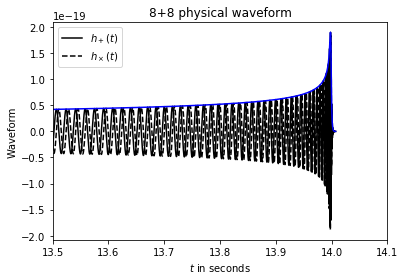

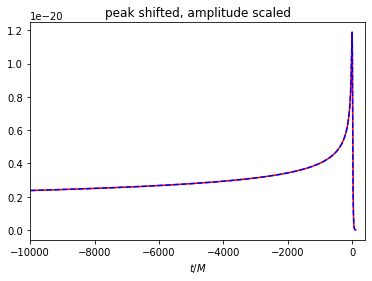

ratio of waveform amplitude peak values:  4.0005111693839375


In [4]:
### Example 1: generate an 8+8 EOB waveform ###
### Example 2: simple comparison between 8+8 and 2+2 EOB waveform ###
Mtot = 16.0 
q    = 1.0
Dist = 1.0 # in megaparsecs
dt   = 1.0/32768.0  # higher sampling rates will yield more accurate comparisons
fmin = 40.0/2.383
incl = 0.0

times, h_16 = EOBNRv2_LAL(Mtot,q,dt,fmin,Dist,incl)
time_16     = gwtools.dimensionless_time(Mtot*lal_MsunInSec, times)

Mtot = 4.0 
fmin = 40.0

time_4, h_4 = EOBNRv2_LAL(Mtot,q,dt,fmin,Dist,incl)
time_4      = gwtools.dimensionless_time(Mtot*lal_MsunInSec ,time_4)

# Example 1, waveform plot....
#plt.pyplot.figure(1)
fig = gwtools.plot_pretty(times,[h_16.real,h_16.imag],showQ=False)
plt.plot(times,np.abs(h_16),'blue')
plt.xlabel('$t$ in seconds')
plt.title('8+8 physical waveform')
plt.xlim(13.5, 14.1)

# Example 2, scaled and shifted waveform peaks (visually, should lie on top of one another)...
plt.figure(2)
plt.plot(time_4 - time_4[np.argmax(np.abs(h_4))],np.abs(h_4)/4.0,'red')
plt.plot(time_16 - time_16[np.argmax(np.abs(h_16))],np.abs(h_16)/16.0,'b--')
plt.xlim(-10000, 400)
plt.xlabel('$t/M$')
plt.title('peak shifted, amplitude scaled')
plt.show()

# Theoretically we expect the ratio of maximum amplitudes to be 16/4...
print( 'ratio of waveform amplitude peak values: ',np.max(np.abs(h_16))/np.max(np.abs(h_4)) )

In [5]:
###  Overall scaling with mass is NOT a free parameter -- scale by exact Mtot...
h_4 = h_4/4.0
h_16 = h_16/16.0

h_4 and h_16 should now be identical after time and phase shifts. Lets check. First, we compute a resonable guess for values of the time/phase shift by (i) discrete search for the peak (i) aligning phases for the shifted waveform. Next, the proper minimization problem is solved.

/home/balzani57/Repo/GitRepos/Codes/gwtools/gwtools/gwtools.py:348: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(111)


overlap error: 1.171195e-02


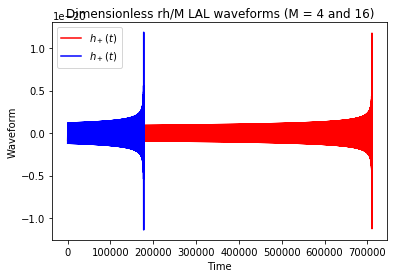

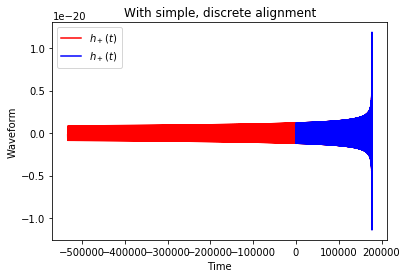

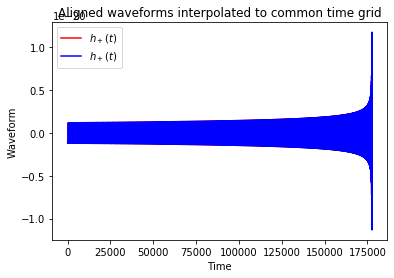

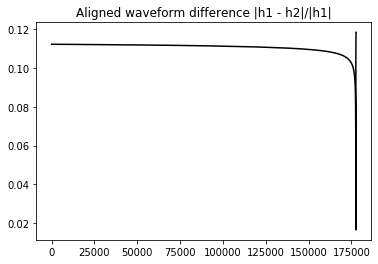

In [6]:
# CASE 1: values for time/phase shift by approximately maximizing over time and phase shifts
gwtools.plot_pretty(time_4,h_4.real,showQ=False,color='r',fignum=1)
gwtools.plot_pretty(time_16,h_16.real,showQ=False,color='b',fignum=1)
plt.title("Dimensionless rh/M LAL waveforms (M = 4 and 16)")

# (Step 1) find reasonable guess for \delta t and \delta phi by...
#          (i)  finding discrete waveform peak
#          (ii) aligning phase values at the peak time
deltaT, deltaPhi = gwtools.simple_align_params(time_4,h_4,time_16,h_16)
h_4              = gwtools.modify_phase(h_4,-deltaPhi)
time_4           = gwtools.coordinate_time_shift(time_4,-deltaT)

gwtools.plot_pretty(time_4,h_4.real,showQ=False,color='r',fignum=2)
gwtools.plot_pretty(time_16,h_16.real,showQ=False,color='b',fignum=2)
plt.title("With simple, discrete alignment")

# (Step 3) With interpolation, represent each waveform as a function
### linear interpolation ###
from scipy.interpolate import interp1d
h_4_interp  = interp1d(time_4,h_4)
h_16_interp = interp1d(time_16,h_16)

# (Step 4) find common temporal window 
common_dt      = (time_4[2] - time_4[1])
t_start, t_end = gwtools.find_common_time_window(time_4,time_16)
common_times   = np.arange(t_start+1,t_end-1,common_dt)

# (Step 5) Evaluate interpolants on a common temporal grid
h_4_eval  = h_4_interp(common_times)
h_16_eval = h_16_interp(common_times)

plt.figure(3)
gwtools.plot_pretty(common_times,h_4_eval.real,showQ=False,color='r',fignum=3)
gwtools.plot_pretty(common_times,h_16_eval.real,showQ=False,color='b',fignum=3)
plt.title("Aligned waveforms interpolated to common time grid")

# (Step 6) Compute a time-domain error
err_h = h_4_eval - h_16_eval
overlap_errors = gwtools.euclidean_rel_error_sqrd(h_4_eval,h_16_eval,common_dt)

plt.figure(4)
plt.plot(common_times,np.abs(err_h)/np.abs(h_4_eval),'black')
plt.title("Aligned waveform difference |h1 - h2|/|h1|")


#############  Report on analysis #############
print("overlap error: %e" %overlap_errors)
plt.show()

Overlap error with discrete minimization: 1.170849e-02
The minimized norm is 2.137078e-05 
For a time shift 3.362508e-01 and phase shift 1.153191e-01 


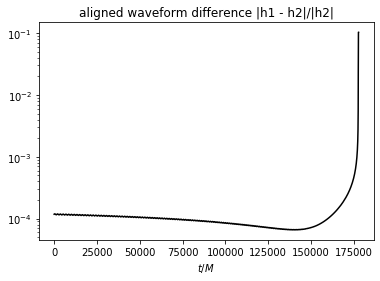

In [7]:
# CASE 2: minimize over 2-dimensional time/phase shift 

### generate a paramterized norm function  ###
h4_parameterized  = gwtools.generate_parameterize_waveform(common_times,h_4_interp,h1_type='interp1d')
ParameterizedNorm = gwtools.generate_parameterized_norm(h4_parameterized,h_16_eval,gwtools.euclidean_norm_sqrd)
print( 'Overlap error with discrete minimization: %e' %ParameterizedNorm([0.0,0.0]) )

### solve minimization problem with nelder-mead algorithm ###
from scipy.optimize import minimize
res_nm = minimize(ParameterizedNorm, [0.0,0.0], method='nelder-mead',tol=1e-12)

### show Nelder-Mead results ###
print( "The minimized norm is %e " %ParameterizedNorm([ res_nm.x[0], res_nm.x[1]]) )
print( "For a time shift %e and phase shift %e " %(res_nm.x[0],res_nm.x[1]) )

common_times_off = gwtools.coordinate_time_shift(common_times,res_nm.x[0])
h_4_eval         = h_4_interp(common_times_off)
h_4_trial        = gwtools.modify_phase(h_4_eval,-res_nm.x[1])
err_h            = h_4_trial - h_16_eval

### compare with analogous plot from CASE 1 above. The errors are now much smaller ###
plt.figure(1)
plt.semilogy(common_times,np.abs(err_h)/np.abs(h_4_eval),'black')
plt.title("aligned waveform difference |h1 - h2|/|h2|")
plt.xlabel('$t/M$')
plt.show()

# Lesson 2: Automated minimization + quantifying EOB/minimization errors

In Lesson 2 we automate the minimiaztion and quantify the comparisons achievable with this procedure. This will set the limit on the best obtainable comparison between EOB LAL function calls and surrogate function calls

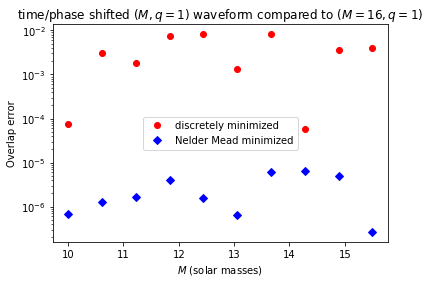

In [8]:
incl = 0.0
fmin = 40.0
dt   = 1.0/32768.0  # higher sampling rates will yield more accurate comparisons
Dist = 1.0

### lets cover a range of total mass values and compare to a fiducial one ###
q = 1.0

# reference 8+8 waveform...
Mtot = 16.0
times, h_16 = EOBNRv2_LAL(Mtot,q,dt,fmin,Dist,incl)
time_16     = gwtools.dimensionless_time(Mtot*lal_MsunInSec,times)
h_16        = h_16/16.0

Mtot_samples = 10
M_list       = np.linspace(10.0,15.5,Mtot_samples)

errors_guess = np.zeros((Mtot_samples,1))
errors_nm    = np.zeros((Mtot_samples,1))

for counter, Mtot in enumerate(M_list):
    
    ### generate a new EOB waveform with LAL and put it into dimensionless form ###
    times, h_tmp = EOBNRv2_LAL(Mtot,q,dt,fmin,Dist,incl)
    time_tmp = gwtools.dimensionless_time(Mtot*lal_MsunInSec,times)
    h_tmp = h_tmp/Mtot
    
    ### minimize the norm ###
    [errors_guess[counter], errors_nm[counter]], [tc, phic], tmp = \
        gwtools.minimize_norm_error(time_tmp,h_tmp,time_16,h_16,\
                                    gwtools.euclidean_norm_sqrd,t_low_adj=.1,t_up_adj=.5,method='nelder-mead')
    
### plot results ###
plt.semilogy(M_list,errors_guess,'or',label='discretely minimized')
plt.semilogy(M_list,errors_nm,'Db',label='Nelder Mead minimized')
plt.xlabel('$M$ (solar masses)')
plt.ylabel('Overlap error')
plt.title('time/phase shifted $(M,q=1)$ waveform compared to $(M=16,q=1)$')
plt.legend()
plt.show()

# Lesson 3: Compare surrogate and EOB modes

In Lesson 3 we shall compare surrogate and LAL-EOB waveforms for the 2,2 mode only. 

Our aim is to show they agree to about 5 digits of relativite accuracy, which is the "error barrier" found in Lesson 2

The comparison will be for physical waveforms covering the (M,q) parameter space

Global minimizer is deltaT = 1.205408e+00 and deltaPhi = 7.173258e+01 
The minimized relative norm error is 2.034275e-04 


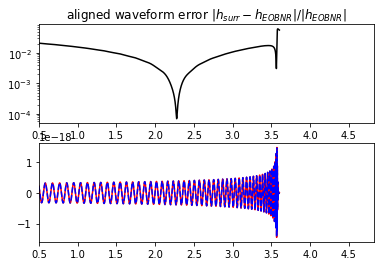

In [14]:
### comparison for physical waveform modes ###
Mtot = 80.0
q    = 1.0
incl = 0.0
Dist = 1.0
fmin = 10.0
dt   = 1.0/2048.0
chiA0 = [0,0,0]
chiB0 = [0,0,0]

# compute harmonic modes #
time_LAL, h_LAL =  generate_LAL_modes(lalsim.EOBNRv2,q,chiA0,chiB0,dt,M=Mtot, \
    dist_mpc=Dist,f_low=fmin,f_ref=20,phi_ref=0.0,ellMax=None, \
    unlimited_extrapolation=False)
h_LAL = np.conj(h_LAL['h_l2m2'])  # Note the conjugation

time_sur,hp,hc  = EOBNRv2_sur(q=q,M=Mtot,dist=Dist,f_low=fmin,ell=[2],m=[2],fake_neg_modes=False)
h_sur           = hp + 1.0j*hc

### minimize the norm error ###
[tmp, minimized_norm], [tc, phic], [t1,h1,h2] = \
    gwtools.minimize_norm_error(time_sur,h_sur,time_LAL,h_LAL,gwtools.euclidean_norm_sqrd,.0125,.0125,method='nelder-mead')
print( "Global minimizer is deltaT = %e and deltaPhi = %e " %(tc,phic) )
print( "The minimized relative norm error is %e " %minimized_norm )

### plot aligned waveforms ###
plt.figure(3)
plt.subplot(2,1,1)
plt.semilogy(t1,np.abs(h1 - h2)/ np.abs(h2),'black')
plt.xlim([0.5, time_sur[-1]])
plt.title("aligned waveform error $|h_{surr} - h_{EOBNR}|/|h_{EOBNR}|$")
plt.subplot(2,1,2)
plt.plot(t1,h1.real,'red')
plt.plot(t1,h2.real,'b--')
plt.xlim([0.5, time_sur[-1]])
plt.show()


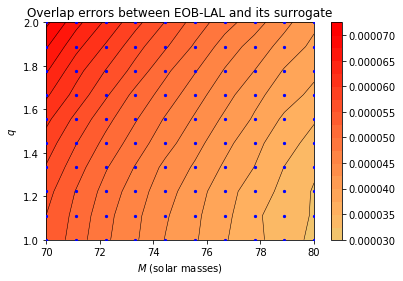

In [17]:
### next, lets compare models over a patch of the parameter space ###
# WARNING: this will take a few minutes

fmin = 11.0
dt = (1.0/4096.0) #Note: setting to larger values could introduce large interpolation error

q_samples = 10
M_samples = 10

errors_nm    = np.zeros((q_samples,M_samples))
q_list       = np.zeros((q_samples,M_samples))
M_list       = np.zeros((q_samples,M_samples))

counter_q = -1
for q in np.linspace(1.0,2.0,q_samples):
    
    counter_M = -1
    counter_q = counter_q + 1
    
    for M in np.linspace(70.0,80.0,M_samples):
   
        counter_M = counter_M + 1
    
        M_list[counter_q,counter_M] = M
        q_list[counter_q,counter_M] = q
    
        ### generate waveforms ###
        time_LAL, h_LAL = generate_LAL_modes(lalsim.EOBNRv2,q,chiA0,chiB0,dt,M=M, \
                    dist_mpc=Dist,f_low=fmin,f_ref=20,phi_ref=0.0,ellMax=None, \
                    unlimited_extrapolation=False)
        h_LAL = np.conj(h_LAL['h_l2m2']) # note the conjugation
        
        time_sur,hp,hc = EOBNRv2_sur(q=q,M=M,dist=Dist,f_low=fmin,fake_neg_modes=False)
        h_sur   = hp + 1.0j*hc

        ### minimize the norm ###
        [tmp, errors_nm[counter_q,counter_M]], tmp1, tmp2 = \
            gwtools.minimize_norm_error(time_sur,h_sur,time_LAL,h_LAL,gwtools.euclidean_norm_sqrd,.1,.1,method='nelder-mead')
            
            
### Display the preceding analysis ###
plt.contour(M_list, q_list, errors_nm, 15, linewidths=0.5, colors='k')
plt.contourf(M_list, q_list, errors_nm, 15, cmap=plt.cm.rainbow,
                  vmax=abs(errors_nm).max(), vmin=-abs(errors_nm).max())
plt.colorbar()  # draw colorbar
plt.scatter(M_list, q_list, marker='o', c='b', s=5, zorder=10)
plt.xlim(np.min(M_list), np.max(M_list))
plt.ylim(np.min(q_list), np.max(q_list))
plt.xlabel('$M$ (solar masses)')
plt.ylabel('$q$')
plt.title('Overlap errors between EOB-LAL and its surrogate')
plt.show()

# Lesson 4: Compare physical surrogate and EOB models

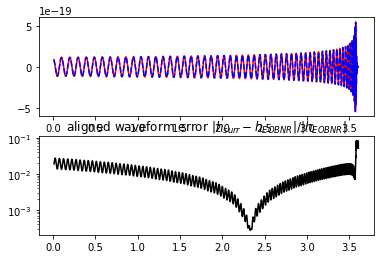

Overlap error =  0.0001375920325977658
Optimal time shift =  1.204778228611085
Optimal phase shift =  36.38494125083804


In [18]:
### comparison for physical waveform modes ###
Mtot = 80.0
q    = 1.0
incl = 2.0 # try 2.0
Dist = 1.0
fmin = 10.0
dt   = 1.0/2048.0

# LAL evaluation... #
time_LAL, h_LAL = EOBNRv2_LAL(Mtot,q,dt,fmin,Dist,incl)

# Compare h_LAL with its surrogate... via gws built-in waveform match function #
min_norm, opt_solution, [t_align, hsur_align, hlal_align] = \
EOBNRv2_sur.match_surrogate(t_ref=time_LAL,h_ref=h_LAL,q=q,M=M,dist=Dist,theta=incl,\
                            t_ref_units='mks',fake_neg_modes=True,t_low_adj=.0125,t_up_adj=.0125,speed='fast')


plt.figure(3)
plt.subplot(2,1,1)
plt.plot(t_align,hsur_align.real,'red')
plt.plot(t_align,hlal_align.real,'b--')
plt.subplot(2,1,2)
plt.semilogy(t_align,np.abs(hsur_align-hlal_align)/ np.abs(hlal_align),'black')
plt.title("aligned waveform error $|h_{surr} - h_{EOBNR}|/|h_{EOBNR}|$")
plt.show()

print( "Overlap error = ",min_norm )
print( "Optimal time shift = ",opt_solution[0] )
print( "Optimal phase shift = ",opt_solution[1] )

0.00013759203259781021


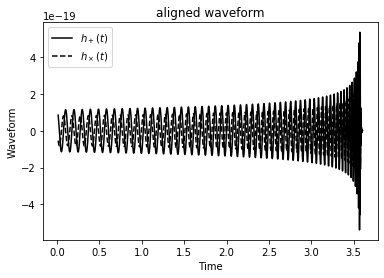

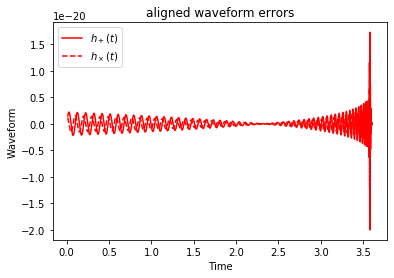

In [19]:
### Directly evaluate surrogate for global minimizers: tc=opt_solution[0], phic=opt_solution[1]###
samples         = t_align + opt_solution[0]
phase_offset    = opt_solution[1]

# evaluate the surrogate #
time_sur1,hp,hc = EOBNRv2_sur(q=q,M=M,dist=Dist,theta=incl,phi=phase_offset,\
                               times=samples,units='mks',fake_neg_modes=True)
h_sur = hp + 1.0j*hc

h_err = h_sur - hlal_align

print( gwtools.euclidean_norm_sqrd(h_err,1.0)/gwtools.euclidean_norm_sqrd(hlal_align,1.0) )

gwtools.plot_pretty(t_align,[hlal_align.real,hlal_align.imag],4,showQ=False)
plt.title("aligned waveform")
gwtools.plot_pretty(t_align,[h_err.real,h_err.imag],5,showQ=False,color='r')
plt.title("aligned waveform errors")
plt.show()

# Lesson 6: frequency domain comparisons

Coming Soon!

# Lesson 7: Multimode models

Coming soon! See also the NR and precessing surrogate notebooks